In [50]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses, get_reward

import seaborn as sns

In [51]:
random_str = "random_traces_v7"
reward_str = "denas_order_v4"
gap_str = "gap_to_baseline_v2"

In [52]:
traces = [
'WIRED_200kbps',
'WIRED_900kbps',
'WIRED_35mbps',
'4G_500kbps',
'4G_700kbps',
'4G_3mbps',
'5G_12mbps',
'5G_13mbps',
'trace_300k']

In [53]:
from best_algs import one_conf_models_dict
list_conf_names = [d[200] for d in one_conf_models_dict.values()]

conff = conf_to_dict(list_conf_names[0])
print(conff)
delay_states = conff["delay_states"]
normalize_states = conff["normalize_states"]
step_time = conff["step_time"]
alg = conff["alg"]
tuned = conff["tuned"]
reward_profile = conff["reward_profile"]

{'trace_path': './traces/WIRED_200kbps.json', 'trace_name': 'WIRED_200kbps', 'delay_states': True, 'normalize_states': True, 'step_time': 200, 'alg': 'TD3', 'tuned': False, 'reward_profile': 0, 'seed': 22}


In [54]:
plot_rr = False
plot_delay = False

prefix = "../output/rates_delay_loss_test_"
suffix = ".pickle"
result_qoe_dict = {}


for test_type in [random_str, reward_str, gap_str]:
    
    result_qoe = []
    
    #Read rates_delay_loss and make l_rate
    pickle_path = prefix+test_type+suffix
    if not os.path.exists(pickle_path):
        print("Pickle doesn't exist: ", pickle_path)
        print("--------------------------")
        continue

    l_rate = pd.read_pickle(pickle_path)

    for trace_name in traces:

        print("Trace: ", trace_name)

        dict_result = {}
        name = trace_name
        REAL_NAME = trace_name

        pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
        l_rate_gcc = pd.read_pickle(pickle_path_gcc)
        trace_name = l_rate_gcc["trace_name"]
        if trace_name != REAL_NAME:
            print("Does not coincide with GCC pickle!")

        dict_result["trace"] = REAL_NAME

        #QoE rr
        U, U_gcc = get_QoE_rr(l_rate, l_rate_gcc, REAL_NAME, step_time, test=True)
        qoe_rr = 100*U.quantile(0.5)
        qoe_rr_gcc = 100*U_gcc.quantile(0.5)
        print("QoE rr:", f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")
        if plot_rr:
            plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(4,2))
            plt.show()

        dict_result["qoe_rr"] = qoe_rr
        # dict_result["qoe_rr_gcc"] = qoe_rr_gcc

        #QoE delay
        delay, delay_gcc, qoe_delay, qoe_delay_gcc = get_QoE_delay(l_rate, l_rate_gcc, REAL_NAME, step_time, test=True)
        print("QoE delay:", f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")
        if plot_delay:
            plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(4,2))
            plt.xlim(0,1000)
            plt.show()

        dict_result["qoe_delay"] = qoe_delay
        # dict_result["qoe_delay_gcc"] = qoe_delay_gcc

        #QoE losses
        loss_ratio, loss_ratio_gcc, qoe_losses, qoe_losses_gcc = get_QoE_losses(l_rate, l_rate_gcc, REAL_NAME, step_time, test=True)
        print("QoE loss:", f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")

        dict_result["qoe_losses"] = round(qoe_losses,2)
        # dict_result["qoe_losses_gcc"] = round(qoe_losses_gcc,2)

        #Overall QoE
        qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
        qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc

        dict_result["qoe"] = qoe
        # dict_result["qoe_gcc"] = qoe_gcc

        print("Overall QoE:", f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")
        print("---------")

        cum_reward, avg_reward = get_reward(l_rate, REAL_NAME, test=True)
        dict_result["avg_reward"] = avg_reward

        result_qoe.append(dict_result)
        
    result_qoe_dict[test_type] = result_qoe


Trace:  WIRED_200kbps
QoE rr: RL: 73.38, GCC: 93.78
QoE delay: RL: 97.31, GCC: 82.47
QoE loss: RL: 100.0, GCC: 100.0
Overall QoE: RL: 90.14, GCC: 91.99
---------
Trace:  WIRED_900kbps
QoE rr: RL: 78.73, GCC: 92.94
QoE delay: RL: 66.03, GCC: 38.37
QoE loss: RL: 100.0, GCC: 100.0
Overall QoE: RL: 81.51, GCC: 77.03
---------
Trace:  WIRED_35mbps
QoE rr: RL: 0.55, GCC: 8.66
QoE delay: RL: 68.51, GCC: 66.51
QoE loss: RL: 99.52, GCC: 99.47
Overall QoE: RL: 56.14, GCC: 58.16
---------
Trace:  4G_500kbps
QoE rr: RL: 65.56, GCC: 78.81
QoE delay: RL: 90.68, GCC: 76.25
QoE loss: RL: 100.0, GCC: 99.83
Overall QoE: RL: 85.33, GCC: 84.88
---------
Trace:  4G_700kbps
QoE rr: RL: 64.12, GCC: 59.77
QoE delay: RL: 89.6, GCC: 89.76
QoE loss: RL: 100.0, GCC: 99.84
Overall QoE: RL: 84.49, GCC: 83.04
---------
Trace:  4G_3mbps
QoE rr: RL: 13.69, GCC: 12.32
QoE delay: RL: 85.03, GCC: 96.79
QoE loss: RL: 89.99, GCC: 87.38
Overall QoE: RL: 62.84, GCC: 65.43
---------
Trace:  5G_12mbps
QoE rr: RL: 1.66, GCC: 4.

## Plot QoE results

In [55]:
df_random = pd.DataFrame(result_qoe_dict[random_str])
df_curr = pd.DataFrame(result_qoe_dict[reward_str])
df_gap_to_b = pd.DataFrame(result_qoe_dict[gap_str])

In [57]:
avg_rew = []
for test_type in [random_str, reward_str, gap_str]:
    
    df = pd.DataFrame(result_qoe_dict[test_type])
    avg_rew.append(df.set_index("trace")["avg_reward"])
    
    print(test_type)
    print(df.drop("avg_reward", axis=1).set_index("trace"))
    

random_traces_v7
                  qoe_rr  qoe_delay  qoe_losses        qoe
trace                                                     
WIRED_200kbps  73.376518  97.309225      100.00  90.138353
WIRED_900kbps  78.731278  66.030103      100.00  81.505540
WIRED_35mbps    0.550545  68.506794       99.52  56.135198
4G_500kbps     65.557688  90.681869      100.00  85.327773
4G_700kbps     64.123081  89.597606      100.00  84.488989
4G_3mbps       13.688817  85.034509       89.99  62.841256
5G_12mbps       1.664893  80.235688      100.00  60.572893
5G_13mbps       1.528333  62.063270      100.00  54.476004
trace_300k     72.506667   2.958580      100.00  58.429927
denas_order_v4
                  qoe_rr  qoe_delay  qoe_losses        qoe
trace                                                     
WIRED_200kbps  76.745763  97.988247      100.00  91.486425
WIRED_900kbps  17.090047  24.561404      100.00  47.169933
WIRED_35mbps    0.435000  66.666667       99.53  55.488177
4G_500kbps     31.057139

In [58]:
df_curr = df_curr.set_index("trace")[["qoe_rr", "qoe_delay", "qoe_losses", "qoe"]]
df_gap_to_b = df_gap_to_b.set_index("trace")[["qoe_rr", "qoe_delay", "qoe_losses", "qoe"]]
df_random = df_random.set_index("trace")[["qoe_rr", "qoe_delay", "qoe_losses", "qoe"]]

In [59]:
dff = df_random.join(df_curr, lsuffix="_random", rsuffix="_rew").join(df_gap_to_b)
dff = dff.apply(lambda x: round(x, 2))
dff = dff[[
    'qoe_rr_random', 'qoe_rr_rew', 'qoe_rr',
           'qoe_delay_random', 'qoe_delay_rew', 'qoe_delay',
            'qoe_losses_random','qoe_losses_rew', 'qoe_losses',
            'qoe_random', 'qoe_rew', 'qoe']]
dff

,qoe_rr_random,qoe_rr_rew,qoe_rr,qoe_delay_random,qoe_delay_rew,qoe_delay,qoe_losses_random,qoe_losses_rew,qoe_losses,qoe_random,qoe_rew,qoe
trace,,,,,,,,,,,,
WIRED_200kbps,73.38,76.75,79.58,97.31,97.99,95.55,100.00,100.00,100.00,90.14,91.49,91.62
WIRED_900kbps,78.73,17.09,70.69,66.03,24.56,63.90,100.00,100.00,100.00,81.51,47.17,78.12
WIRED_35mbps,0.55,0.43,1.93,68.51,66.67,72.99,99.52,99.53,99.57,56.14,55.49,58.10
4G_500kbps,65.56,31.06,75.01,90.68,93.83,89.56,100.00,100.00,100.00,85.33,74.89,88.10
4G_700kbps,64.12,23.06,69.02,89.60,93.80,89.40,100.00,100.00,100.00,84.49,72.22,86.05
4G_3mbps,13.69,5.16,9.75,85.03,87.75,95.55,89.99,86.42,84.74,62.84,59.72,63.28
5G_12mbps,1.66,1.14,4.73,80.24,50.06,70.74,100.00,100.00,100.00,60.57,50.35,58.43
5G_13mbps,1.53,1.07,4.36,62.06,47.56,55.92,100.00,100.00,99.97,54.48,49.49,53.36
trace_300k,72.51,46.72,66.95,2.96,0.00,48.43,100.00,100.00,100.00,58.43,48.86,71.72


<AxesSubplot:xlabel='trace'>

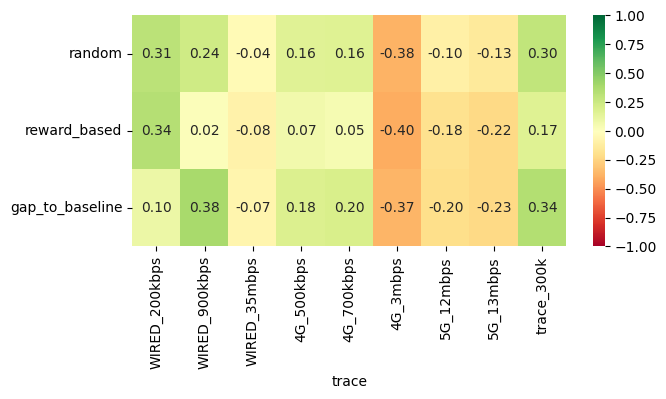

In [10]:
df_rew = pd.DataFrame(avg_rew, index=["random", "reward_based", "gap_to_baseline"])
plt.figure(figsize=(7,3))
sns.heatmap(df_rew, annot=True, fmt=".2f", cmap="RdYlGn", vmin=-1, vmax=1)

## Plot training data

In [12]:
from matplotlib import rcParams
#IEEE Times New Roman (Nimbus Roman)
rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

#Latex in general
rcParams['font.family'] = "serif"
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

## Old plot - just from one run

In [11]:
train_curr = pd.read_csv("~/RL_rtc/simulation_analysis/inputs_tensorboard/denas_order_v1.csv")
train_random = pd.read_csv("~/RL_rtc/simulation_analysis/inputs_tensorboard/random_traces_v4_0.csv")
train_gap = pd.read_csv("~/RL_rtc/simulation_analysis/inputs_tensorboard/gap_to_baseline.csv")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


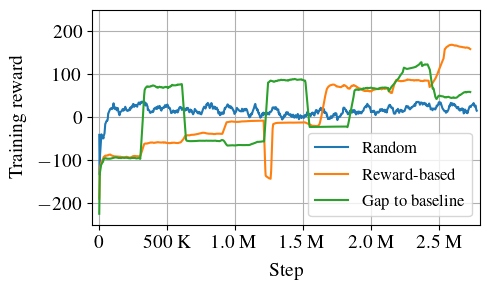

In [13]:
from matplotlib.ticker import FuncFormatter
mkfunc = lambda x, pos: '%1.1f M' % (x * 1e-6) if x >= 1e6 else '%1.f K' % (x * 1e-3) if x >= 1e3 else '%1.f' % x
mkformatter = FuncFormatter(mkfunc)

fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)
ax.xaxis.set_major_formatter(mkformatter)
ax.plot(train_random["Step"], train_random["Value"], label="Random")
ax.plot(train_curr["Step"], train_curr["Value"], label="Reward-based")
ax.plot(train_gap["Step"], train_gap["Value"], label="Gap to baseline")
plt.ylim(-250, 250)
plt.xlim(-50000,2800000)
plt.xlabel("Step", fontsize=fontsize, labelpad=8)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=8)
plt.legend(loc="lower right", fontsize=fontsize-2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()
# plt.savefig("plots/one_model_training.pdf")

## Look at random training

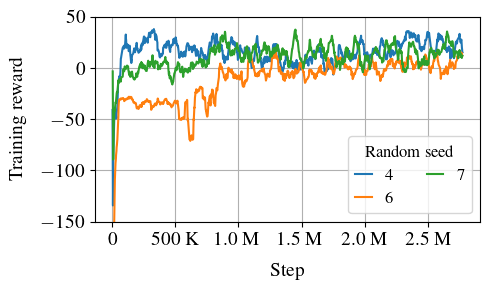

In [32]:
special_df = pd.read_csv(f"~/RL_rtc/simulation_analysis/inputs_tensorboard/random_traces/random_traces_v1_1.csv")

from matplotlib.ticker import FuncFormatter
mkfunc = lambda x, pos: '%1.1f M' % (x * 1e-6) if x >= 1e6 else '%1.f K' % (x * 1e-3) if x >= 1e3 else '%1.f' % x
mkformatter = FuncFormatter(mkfunc)

fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)
df_big = pd.DataFrame()

for i in [4,6,7]:
    dff = pd.read_csv(f"~/RL_rtc/simulation_analysis/inputs_tensorboard/random_traces/random_traces_v{i}_0.csv")
    
    if i==1:
        dff = pd.concat([special_df,dff]).reset_index(drop=True)
    
    df_big = pd.concat([df_big, dff.reset_index()], axis=1)
    
    ax.plot(dff["Step"], dff["Value"], label=f"{i}")

ax.xaxis.set_major_formatter(mkformatter)
plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()

# plt.savefig("plots/random_training.pdf")

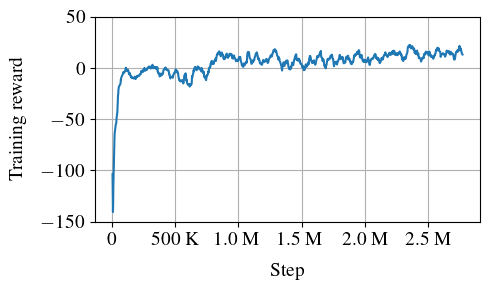

In [33]:
random_step_mean = df_big.Step.dropna().mean(axis=1)
random_value_mean = df_big.Value.dropna().mean(axis=1)

fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(random_step_mean, random_value_mean)
ax.xaxis.set_major_formatter(mkformatter)
plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
# plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           # handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()


## Look at denas order training

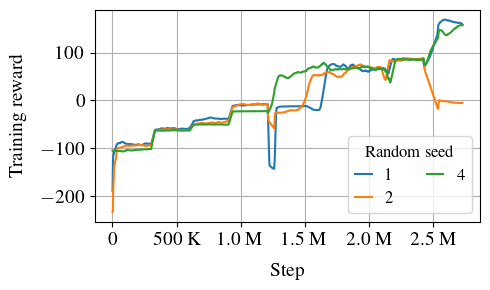

In [34]:
fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)
df_big_reward = pd.DataFrame()

for i in [1,2,4]:

    dff = pd.read_csv(f"~/RL_rtc/simulation_analysis/inputs_tensorboard/reward_based/denas_order_v{i}.csv")
    
    ax.plot(dff["Step"], dff["Value"], label=f"{i}")
    df_big_reward = pd.concat([df_big_reward, dff.reset_index()], axis=1)

ax.xaxis.set_major_formatter(mkformatter)
# plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()

In [35]:
reward_step_mean = df_big_reward.Step.dropna().mean(axis=1)
reward_value_mean = df_big_reward.Value.dropna().mean(axis=1)

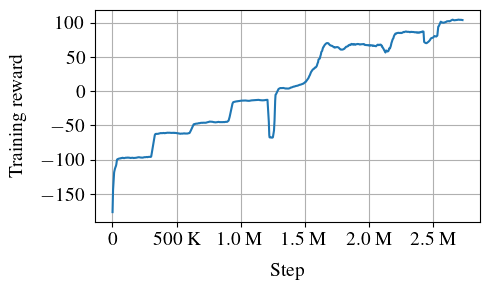

In [36]:
fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(reward_step_mean, reward_value_mean)
ax.xaxis.set_major_formatter(mkformatter)
# plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
# plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           # handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()

## Look at gap-to-baseline training

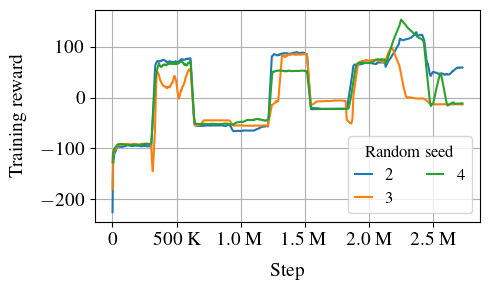

In [37]:
fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)
df_big_gap = pd.DataFrame()

for i in range(2,5):
    dff = pd.read_csv(f"~/RL_rtc/simulation_analysis/inputs_tensorboard/gap_to_baseline/gap_to_baseline_v{i}_TD3_0.csv")
    
    ax.plot(dff["Step"], dff["Value"], label=f"{i}")
    df_big_gap = pd.concat([df_big_gap, dff.reset_index()], axis=1)

ax.xaxis.set_major_formatter(mkformatter)
# plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()

In [38]:
gap_step_mean = df_big_gap.Step.dropna().mean(axis=1)
gap_value_mean = df_big_gap.Value.dropna().mean(axis=1)

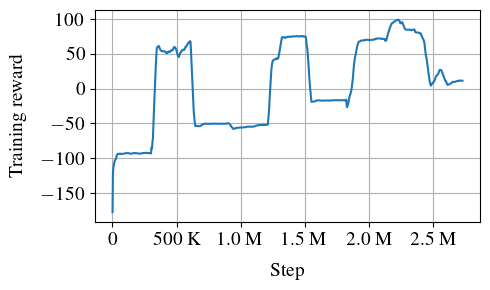

In [39]:
fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(gap_step_mean, gap_value_mean)
ax.xaxis.set_major_formatter(mkformatter)
# plt.ylim(-150, 50)
# plt.xlim(-30000,1000000)
plt.xlabel("Step", fontsize=fontsize, labelpad=10)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=10)
# plt.legend(loc="lower right", fontsize=fontsize-2, title="Random seed",
           # handlelength=1, title_fontsize=12, labelspacing = 0.3, ncol=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()

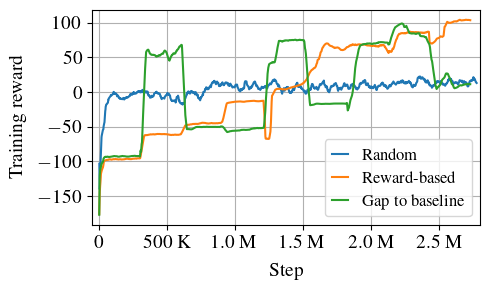

In [43]:
fontsize=14
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize)
ax.xaxis.set_major_formatter(mkformatter)
ax.plot(random_step_mean, random_value_mean, label="Random")
ax.plot(reward_step_mean, reward_value_mean, label="Reward-based")
ax.plot(gap_step_mean, gap_value_mean, label="Gap to baseline")
# plt.ylim(-250, 250)
plt.xlim(-50000,2800000)
plt.xlabel("Step", fontsize=fontsize, labelpad=8)
plt.ylabel("Training reward", fontsize=fontsize, labelpad=8)
plt.legend(loc="lower right", fontsize=fontsize-2, handlelength=1, labelspacing = 0.3)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.tight_layout()
plt.savefig("plots/one_model_training_avg.pdf")